In [1]:
import pandas as pd
import os
import numpy as np
from pyproj import Transformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
import gc
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from haversine import haversine, Unit
from shapely.ops import unary_union
from geopy.distance import geodesic
from shapely.geometry import Point
import random
from itertools import combinations
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.cluster import AgglomerativeClustering
from pyproj import Transformer
from geopy.geocoders import Nominatim
random.seed(42)
np.random.seed(42)
# Show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Data Cleaning

In [2]:
save_dir = r'C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410'
os.makedirs(save_dir, exist_ok=True)

# Define the directory path
data_dir = save_dir

# Define file paths
sequences_path = data_dir + r'\ssusa_finalsequences.csv'
deployments_path = data_dir + r'\ssusa_finaldeployments.csv'

# Load the CSV files
sequences_df = pd.read_csv(sequences_path)
print(f"Number of records in sequences_df: {len(sequences_df)}")
deployments_df = pd.read_csv(deployments_path)
print(f"Number of records in deployments_df: {len(deployments_df)}")

Number of records in sequences_df: 987979
Number of records in deployments_df: 9679


C:\Users\sagni\AppData\Local\Temp\ipykernel_6120\3888890389.py:12: DtypeWarning: Columns (4,15) have mixed types. Specify dtype option on import or set low_memory=False.
  sequences_df = pd.read_csv(sequences_path)


In [3]:
# List of required columns
required_cols = ['Class', 'Order', 'Family', 'Genus', 'Species', 'Common_Name']

# Replace single space strings with actual NaN
sequences_df[required_cols] = sequences_df[required_cols].replace(' ', pd.NA)

# Count before filtering
initial_count = len(sequences_df)

# Drop rows with any missing values in required columns
sequences_df = sequences_df.dropna(subset=required_cols)

# Count after filtering
final_count = len(sequences_df)
deleted_count = initial_count - final_count

# Print results
print(f"Number of records deleted: {deleted_count}")
print(f"Final number of records: {final_count}")

Number of records deleted: 96032
Final number of records: 891947


In [4]:
# Get all common columns
common_cols = set(sequences_df.columns).intersection(deployments_df.columns)
print(common_cols)

# Merge on both 'Deployment_ID' and 'Year'
merged_df = pd.merge(
    sequences_df, 
    deployments_df, 
    on=list(common_cols), 
    how='inner'
)

merged_df = merged_df.drop_duplicates()

print(f"Number of records in merged_df: {len(merged_df)}")

{'Deployment_ID', 'Year', 'Camera_Trap_Array', 'Project'}
Number of records in merged_df: 885087


In [5]:
# Columns to convert to Proper Case
prop_case_cols = [
    'Class', 'Order', 'Family', 'Genus', 'Species', 'Habitat', 
    'Development_Level', 'Feature_Type', 'Common_Name', 
    'Site_Name', 'Age', 'Sex'
]

# First, replace blank or whitespace-only strings with NaN for Age, Sex, and Group_Size
merged_df[['Age', 'Sex', 'Group_Size']] = merged_df[['Age', 'Sex', 'Group_Size']].replace(r'^\s*$', pd.NA, regex=True)

# Group_Size: Replace missing with 0 and convert to numeric
merged_df['Group_Size'] = merged_df['Group_Size'].fillna(0)
merged_df['Group_Size'] = pd.to_numeric(merged_df['Group_Size'], errors='coerce').fillna(0).astype(int)

# Age and Sex: Replace missing with 'Unknown'
merged_df['Age'] = merged_df['Age'].fillna('Unknown')
merged_df['Sex'] = merged_df['Sex'].fillna('Unknown')

# Now apply proper case to selected columns
for col in prop_case_cols:
    merged_df[col] = merged_df[col].str.lower()

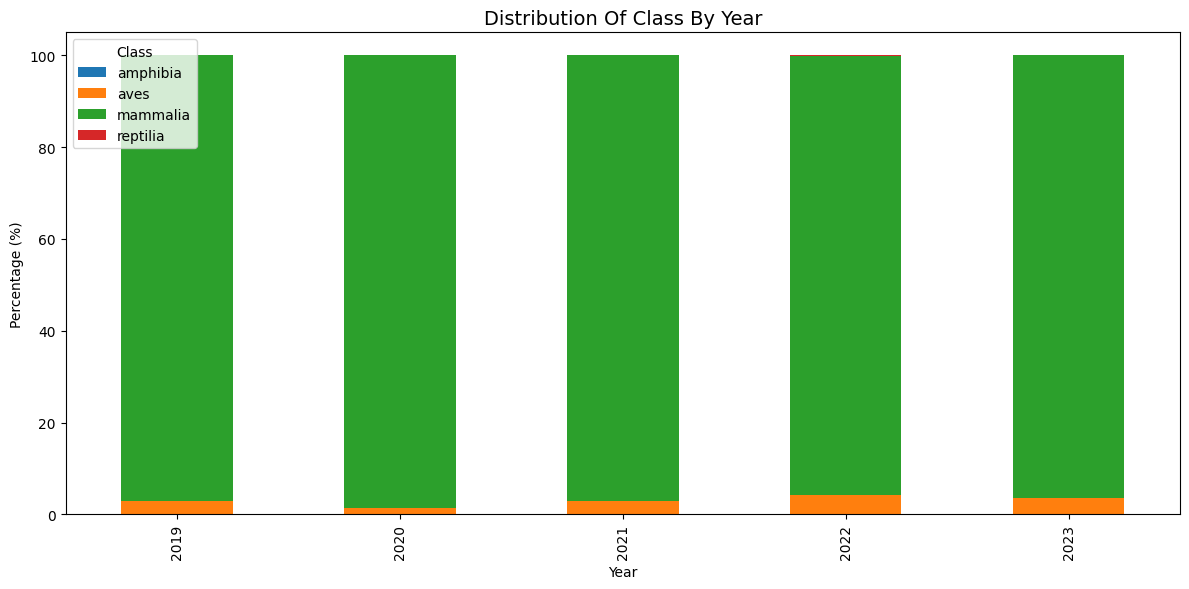

In [6]:
# Step 1: Group by Year and Class, count records
class_year_counts = (
    merged_df.groupby(['Year', 'Class'])
    .size()
    .unstack(fill_value=0)
)

# Step 2: Convert to percentages row-wise
class_year_pct = class_year_counts.div(class_year_counts.sum(axis=1), axis=0) * 100

# Step 3: Plot 100% stacked bar chart
class_year_pct.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6)
)

plt.title("Distribution Of Class By Year", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Percentage (%)")
plt.legend(title="Class", loc='upper left')
plt.tight_layout()
plt.show()


In [7]:
merged_df = merged_df[merged_df['Class'] == 'mammalia']
print(f"Number of records in merged_df: {len(merged_df)}")
print(f"Number of columns in merged_df: {merged_df.shape[1]}")

Number of records in merged_df: 857003
Number of columns in merged_df: 25


In [8]:
merged_df.head()

,Year,Project,Camera_Trap_Array,Deployment_ID,Sequence_ID,Start_Time,End_Time,Class,Order,Family,Genus,Species,Common_Name,Age,Sex,Group_Size,Site_Name,Start_Date,End_Date,Survey_Nights,Latitude,Longitude,Habitat,Development_Level,Feature_Type
0,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s1,2019/08/31 06:50:00,2019/08/31 06:50:00,mammalia,carnivora,ursidae,ursus,arctos,brown bear,unknown,unknown,1,ak_forest_crupi_21_dep_01,2019-08-31,2019-11-03,64,59.42643,-136.2225,forest,wild,water source
1,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s2,2019/08/31 14:15:00,2019/08/31 14:17:00,mammalia,carnivora,ursidae,ursus,arctos,brown bear,unknown,unknown,1,ak_forest_crupi_21_dep_01,2019-08-31,2019-11-03,64,59.42643,-136.2225,forest,wild,water source
2,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s3,2019/08/31 18:22:00,2019/08/31 18:22:00,mammalia,carnivora,ursidae,ursus,arctos,brown bear,unknown,unknown,1,ak_forest_crupi_21_dep_01,2019-08-31,2019-11-03,64,59.42643,-136.2225,forest,wild,water source
3,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s4,2019/08/31 20:58:00,2019/08/31 20:58:00,mammalia,carnivora,ursidae,ursus,arctos,brown bear,adult,female,1,ak_forest_crupi_21_dep_01,2019-08-31,2019-11-03,64,59.42643,-136.2225,forest,wild,water source
4,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s4,2019/08/31 20:58:00,2019/08/31 20:58:00,mammalia,carnivora,ursidae,ursus,arctos,brown bear,juvenile,unknown,2,ak_forest_crupi_21_dep_01,2019-08-31,2019-11-03,64,59.42643,-136.2225,forest,wild,water source


## Clustering

In [9]:
deployments_df = deployments_df.drop_duplicates(subset='Deployment_ID', keep='first')

deployments_df = deployments_df[deployments_df['Deployment_ID'].isin(merged_df['Deployment_ID'])]

def latlon_to_utm_zone(lat, lon):
    utm_zone = int((lon + 180) / 6) + 1
    is_northern = lat >= 0
    epsg_code = 32600 + utm_zone if is_northern else 32700 + utm_zone
    return epsg_code

# Example: pick appropriate UTM zone dynamically
mean_lat = deployments_df['Latitude'].mean()
mean_lon = deployments_df['Longitude'].mean()
utm_epsg = latlon_to_utm_zone(mean_lat, mean_lon)

transformer = Transformer.from_crs("epsg:4326", f"epsg:{utm_epsg}", always_xy=True)

deployments_df['x'], deployments_df['y'] = transformer.transform(
    deployments_df['Longitude'].values,
    deployments_df['Latitude'].values
)

# === Step 1: K-means === #
deployments_df['x'], deployments_df['y'] = transformer.transform(
    deployments_df['Longitude'].values,
    deployments_df['Latitude'].values
)


# Use projected coords 'x', 'y' (in meters)
# agglo = AgglomerativeClustering(
#     n_clusters=None,          # Use distance threshold mode
#     distance_threshold=50000, # 50 km in meters
#     linkage='single'          # single linkage to ensure max pairwise distance in cluster <= threshold
# )
agglo = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=50000,
    linkage='complete'  # Ensures max pairwise distance within cluster <= threshold
)

deployments_df['Cluster_Agglo'] = agglo.fit_predict(deployments_df[['x', 'y']])

deployments_df.head()

,Year,Project,Camera_Trap_Array,Site_Name,Deployment_ID,Start_Date,End_Date,Survey_Nights,Latitude,Longitude,Habitat,Development_Level,Feature_Type,x,y,Cluster_Agglo
0,2022,Lex SKUNK,Sovie,Harrods Hill,Harrods Hill 08/06/2022,2022-09-01,2022-10-29,58,38.0164,-84.5642,Anthropogenic,Urban,Trail game,1.241122e+06,4.241374e+06,38
1,2022,Lex SKUNK,Sovie,Idle Hour,Idle Hour 08/06/2022,2022-09-01,2022-10-28,57,38.0200,-84.4586,Anthropogenic,Urban,Trail game,1.250379e+06,4.242629e+06,38
2,2022,Lex SKUNK,Sovie,Jacobson Park,Jacobson Park 08/06/2022,2022-09-01,2022-10-29,58,37.9886,-84.4158,Anthropogenic,Urban,Trail game,1.254470e+06,4.239485e+06,38
3,2022,Lex SKUNK,Sovie,Lake View,Lake View 08/06/2022,2022-09-03,2022-10-30,57,38.0125,-84.4705,Anthropogenic,Urban,Trail game,1.249408e+06,4.241698e+06,38
4,2022,Lex SKUNK,Sovie,Lexington Cemetery,Lexington Cemetery 09/30/2022,2022-10-01,2022-10-30,29,38.0630,-84.5124,Anthropogenic,Urban,Other,1.245204e+06,4.246976e+06,38


In [10]:
plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    truncate_mode='lastp',
    p=15,  # Show only top 15 cluster merges
    show_contracted=True,
    color_threshold=50000
)
plt.title("Dendrogram (Top 15 Cluster Merges)", fontsize=14)
plt.xlabel("Merged Clusters")
plt.ylabel("Distance (meters)")
plt.axhline(y=50000, color='red', linestyle='--', label='50 km Threshold')
plt.legend()
plt.tight_layout()
plt.savefig(r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\plots\Dendogram_Top15.png", dpi=600, bbox_inches='tight')
plt.show()

NameError: name 'dendrogram' is not defined

<Figure size 1200x600 with 0 Axes>

In [ ]:
# Step 1: Create GeoDataFrame from deployments_df
geometry = [Point(xy) for xy in zip(deployments_df['Longitude'], deployments_df['Latitude'])]
gdf = gpd.GeoDataFrame(deployments_df, geometry=geometry, crs="EPSG:4326")

# Step 2: Count points per cluster
cluster_counts = gdf['Cluster_Agglo'].value_counts()
min_points = 2  # Threshold for small clusters
small_clusters = cluster_counts[cluster_counts < min_points].index.tolist()
large_clusters = cluster_counts[cluster_counts >= min_points].index.tolist()

# Step 3: Compute centroids of clusters (in lat/lon)
centroids = (
    gdf.groupby('Cluster_Agglo')['geometry']
    .apply(lambda x: unary_union(x).centroid)
    .reset_index()
)
centroids.columns = ['Cluster_Agglo', 'geometry']
centroids['coords'] = centroids['geometry'].apply(lambda point: (point.y, point.x))  # (lat, lon)

# Step 4: Map small clusters to nearest large cluster centroid
reassignment_map = {}

for small in small_clusters:
    small_coord = centroids.loc[centroids['Cluster_Agglo'] == small, 'coords'].values[0]

    # Find nearest large cluster centroid using geodesic distance
    nearest_cluster = min(
        large_clusters,
        key=lambda lc: geodesic(
            small_coord,
            centroids.loc[centroids['Cluster_Agglo'] == lc, 'coords'].values[0]
        ).kilometers
    )
    reassignment_map[small] = nearest_cluster

# Step 5: Reassign small cluster points to nearest large cluster
def reassign_cluster(row):
    if row['Cluster_Agglo'] in reassignment_map:
        return reassignment_map[row['Cluster_Agglo']]
    return row['Cluster_Agglo']

gdf['Cluster_Agglo_Updated'] = gdf.apply(reassign_cluster, axis=1)

# If you want to update deployments_df with new cluster assignments:
deployments_df['Cluster_Agglo'] = gdf['Cluster_Agglo_Updated']

In [ ]:
# Get unique updated cluster IDs and sort them
unique_clusters = sorted(deployments_df['Cluster_Agglo'].unique())

# Create mapping from old cluster ID → new sequential ID
new_cluster_id_map = {old_id: new_id for new_id, old_id in enumerate(unique_clusters)}

# Apply mapping
deployments_df['Cluster_Agglo'] = deployments_df['Cluster_Agglo'].map(new_cluster_id_map)

In [ ]:
# Get frequency counts sorted by cluster ID
freq = deployments_df['Cluster_Agglo'].value_counts().sort_index()

# Convert to DataFrame and add serial number starting from 1
freq_df = freq.reset_index()
freq_df.columns = ['Cluster_Agglo', 'Frequency']
freq_df.insert(0, 'Serial_No', range(1, len(freq_df) + 1))

print(freq_df)

In [ ]:
gc.collect()

In [ ]:
print(len(deployments_df))

In [ ]:
# Perform the join
merged_df = merged_df.merge(
    deployments_df[['Deployment_ID', 'x', 'y', 'Cluster_Agglo']],  # Only bring needed columns
    on='Deployment_ID',
    how='left'  # Preserve all rows from merged_df
)
print(f"Number of records in merged_df: {len(merged_df)}")
print(f"Number of columns in merged_df: {merged_df.shape[1]}")

## Clystering vizualization

In [ ]:
# Create GeoDataFrame from deployments_df
geometry = [Point(xy) for xy in zip(deployments_df['Longitude'], deployments_df['Latitude'])]
gdf = gpd.GeoDataFrame(deployments_df, geometry=geometry, crs="EPSG:4326")

# Convert to Web Mercator for basemap
gdf = gdf.to_crs(epsg=3857)

# Compute centroids
centroids = gdf.groupby('Cluster_Agglo')['geometry'].apply(lambda x: x.unary_union.centroid)
centroids_gdf = gpd.GeoDataFrame(centroids, geometry='geometry', crs=gdf.crs).reset_index()

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot datapoints as small blue dots
gdf.plot(ax=ax, color='blue', markersize=3, alpha=0.6, label='Data Points')

# Plot centroids as larger dark red dots
centroids_gdf.plot(ax=ax, color='darkred', markersize=20, label='Centroids')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add legend
ax.legend(markerscale=2, fontsize=12)

# Style
ax.set_title('Clusters and Centroids', fontsize=16)
ax.set_axis_off()
plt.savefig(r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\plots\Agglo_cluster_centroids.png", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# === Replace with your actual cluster IDs ===
cluster_ids_to_plot = [4,	5,	2,	3,	1,	10,	11,	0,	6,	8]

# Create GeoDataFrame if not already done
geometry = [Point(xy) for xy in zip(deployments_df['Longitude'], deployments_df['Latitude'])]
gdf = gpd.GeoDataFrame(deployments_df, geometry=geometry, crs="EPSG:4326")

# Convert to Web Mercator (for basemap compatibility)
gdf = gdf.to_crs(epsg=3857)

# Filter only selected clusters
gdf_subset = gdf[gdf['Cluster_Agglo'].isin(cluster_ids_to_plot)]

# Set up plot
fig, ax = plt.subplots(figsize=(12, 10))

# Define color map
cmap = cm.get_cmap('tab10', len(cluster_ids_to_plot))

# Plot each cluster with unique color
for i, cluster_id in enumerate(cluster_ids_to_plot):
    cluster_data = gdf_subset[gdf_subset['Cluster_Agglo'] == cluster_id]
    cluster_data.plot(ax=ax, markersize=10, color=cmap(i), label=f'Cluster {cluster_id}', alpha=0.8)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Styling
ax.set_title("Selected Clusters", fontsize=16)
ax.legend(markerscale=1.5, fontsize=10)
ax.set_axis_off()

plt.tight_layout()
plt.savefig(r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\plots\Agglo_cluster_top10_max_dist.png", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
#Cluster metrics
def cluster_distance_stats_df(
    df,
    cluster_col='Cluster_KMeans',
    lat_col='Latitude',
    lon_col='Longitude',
    output_dir=r'C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410'
):
    clusters = df[cluster_col].unique()
    results = []

    for c in sorted(clusters):
        cluster_points = df[df[cluster_col] == c][[lat_col, lon_col]].values
        
        count = len(cluster_points)
        if count < 2:
            results.append({
                'cluster_id': c,
                'count': count,
                'min_distance_km': np.nan,
                'avg_distance_km': np.nan,
                'max_distance_km': np.nan
            })
            continue
        
        distances = [
            geodesic((lat1, lon1), (lat2, lon2)).km
            for (lat1, lon1), (lat2, lon2) in combinations(cluster_points, 2)
        ]
        
        results.append({
            'cluster_id': c,
            'count': count,
            'min_distance_km': min(distances),
            'avg_distance_km': sum(distances) / len(distances),
            'max_distance_km': max(distances)
        })
    
    Output = pd.DataFrame(results).sort_values('cluster_id').reset_index(drop=True)
    
    # Ensure directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Full path for output file
    filename = f"{cluster_col}.xlsx"
    filepath = os.path.join(output_dir, filename)
    
    Output.to_excel(filepath, index=False)
    
    return Output

In [ ]:
cluster_stats_df = cluster_distance_stats_df(
    deployments_df, 
    cluster_col='Cluster_Agglo'
)
print(cluster_stats_df)

In [ ]:
# Create figure and plot
output_dir = r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\plots"
fig_path = os.path.join(output_dir, "BoxPlot_IntraCluster_Distance.png")
plt.figure(figsize=(6,8))  # Taller for vertical box plot

plt.boxplot(cluster_stats_df['max_distance_km'].dropna(), vert=True)

plt.title('Box Plot Of Max. Intra-Cluster Distance')
plt.ylabel('Max. Intra-Cluster Distance (Km.)')

# Remove x-axis labels/ticks
plt.xticks([])

# Add horizontal line at y=50
plt.axhline(y=50, color='red', linestyle='--', linewidth=2)

# Save the figure
# plt.savefig(fig_path, dpi=600, bbox_inches='tight')

plt.savefig(r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\plots\Agglo_cluster_boxplot_max_dist.png", dpi=600, bbox_inches='tight')
plt.show()

## Save Dataset

In [ ]:
# !pip install XlsxWriter

In [ ]:
output_path = r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\Data_Clustered_Cleaned.csv"
merged_df.to_csv(output_path, index=False)

## Name the cluster

In [12]:
# File path
file_path = r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\Data_Clustered_Cleaned.csv"

# Read CSV into dataframe
merged_df = pd.read_csv(file_path)

# Select relevant columns
subset = merged_df[['Latitude', 'Longitude', 'Cluster_Agglo']]

# Group by Cluster_Agglo and find mean lat/lon
cluster_means = subset.groupby('Cluster_Agglo')[['Latitude', 'Longitude']].mean().reset_index()

geolocator = Nominatim(user_agent="geoapi")

def get_city_state(lat, lon):
    try:
        location = geolocator.reverse(f"{lat}, {lon}", language='en')
        address = location.raw['address']
        city = next((address.get(k) for k in [
            'city', 'town', 'village', 'hamlet', 'municipality', 'locality', 'suburb', 'neighbourhood'
        ]), None)
        if city is None:
            city = address.get('county', 'Unknown')
        state = address.get('state', 'Unknown')
        return f"{city} - {state}"
    except Exception as e:
        # print(f"Error for {lat}, {lon}: {e}")
        return "Unknown, Unknown"

# Apply reverse geocoding to each cluster mean coordinate
cluster_means['City_State'] = cluster_means.apply(
    lambda row: get_city_state(row['Latitude'], row['Longitude']), axis=1
)

# Print pre and post record counts
print(f"Original records: {len(merged_df)}")
print(f"Clusters found: {len(cluster_means)}")

# Merge City_State back to original dataframe on Cluster_Agglo
merged_df = merged_df.merge(cluster_means[['Cluster_Agglo', 'City_State']], on='Cluster_Agglo', how='left')
print(f"After join: {len(merged_df)}")

C:\Users\sagni\AppData\Local\Temp\ipykernel_6120\828237929.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv(file_path)


Original records: 857003
Clusters found: 211
After join: 857003


In [13]:
output_path = r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\Data_Clustered_Cleaned_Named.xlsx"
merged_df.to_excel(output_path, index=False, engine='xlsxwriter')

## Name the cluster

In [2]:
# File path
file_path = r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\Data_Clustered_Cleaned_50km.csv"

# Read CSV into dataframe
merged_df = pd.read_csv(file_path)

# Select relevant columns
subset = merged_df[['Latitude', 'Longitude', 'Cluster_Agglo']]

# Group by Cluster_Agglo and find mean lat/lon
cluster_means = subset.groupby('Cluster_Agglo')[['Latitude', 'Longitude']].mean().reset_index()

geolocator = Nominatim(user_agent="geoapi")

def get_city_state(lat, lon):
    try:
        location = geolocator.reverse(f"{lat}, {lon}", language='en')
        address = location.raw['address']
        city = next((address.get(k) for k in [
            'city', 'town', 'village', 'hamlet', 'municipality', 'locality', 'suburb', 'neighbourhood'
        ]), None)
        if city is None:
            city = address.get('county', 'Unknown')
        state = address.get('state', 'Unknown')
        return f"{city} - {state}"
    except Exception as e:
        # print(f"Error for {lat}, {lon}: {e}")
        return "Unknown, Unknown"

# Apply reverse geocoding to each cluster mean coordinate
cluster_means['City_State'] = cluster_means.apply(
    lambda row: get_city_state(row['Latitude'], row['Longitude']), axis=1
)

# Print pre and post record counts
print(f"Original records: {len(merged_df)}")
print(f"Clusters found: {len(cluster_means)}")

# Merge City_State back to original dataframe on Cluster_Agglo
merged_df = merged_df.merge(cluster_means[['Cluster_Agglo', 'City_State']], on='Cluster_Agglo', how='left')
print(f"After join: {len(merged_df)}")

C:\Users\sagni\AppData\Local\Temp\ipykernel_3320\1259162555.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv(file_path)


Original records: 772478
Clusters found: 211
After join: 772478


In [4]:
output_path = r"C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410\Data_Clustered_Cleaned_50km.csv"
merged_df.to_csv(output_path, index=False)